# Net Apparent Production Correction

In [147]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from importlib import reload
import warnings
warnings.filterwarnings('ignore')

/Users/akbaskind/Documents/Python Scripts/phyto


# Prep data
1. Pull from spreadsheets
2. Correct data types
3. Rename variables
4. Convert oxygen from mg/L to umol/kg

In [148]:
#The scope is always look like this so we did not need to change anything

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Spreadsheet key
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

# Worksheet keys
wks_hydrocat620 = 'Hydrocat 620'
wks_hydrocat720 = 'Hydrocat 720'
wks_MV = 'MV'
wks_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

## HYDROCAT 620
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat620)
values = sheet.get_all_values()
hydrocat620 = pd.DataFrame(values[1:], columns = values[0])


## HYDROCAT 720
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat720)
values = sheet.get_all_values()
hydrocat720 = pd.DataFrame(values[1:], columns = values[0])

## MV
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_MV)
values = sheet.get_all_values()
MV = pd.DataFrame(values[1:], columns = values[0])

## QP
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_QP)
values = sheet.get_all_values()
QP = pd.DataFrame(values[1:], columns = values[0])

In [149]:
for k in hydrocat620.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat620[k] = pd.to_datetime(hydrocat620[k])
    else:
        hydrocat620[k] = pd.to_numeric(hydrocat620[k])

for k in hydrocat720.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat720[k] = pd.to_datetime(hydrocat720[k])
    else:
        hydrocat720[k] = pd.to_numeric(hydrocat720[k])
        
for k in QP.keys():
    if k == 'DateTime' or k == 'time':
        QP[k] = pd.to_datetime(QP[k])
    else:
        QP[k] = pd.to_numeric(QP[k])
        
for k in MV.keys():
    if k == 'DateTime' or k == 'time':
        MV[k] = pd.to_datetime(MV[k])
    else:
        MV[k] = pd.to_numeric(MV[k])
               

## Oxygen unit conversion

Since our `o2sat(S,T)` function has units of umol/kg and our sensor DO has units of mg/L, let's convert our sensor DO to umol/kg. Remember that oxygen (O$_2$) is 32 g/mol.

$$ 
\frac{\color{purple}{\text{mg}_{\text{O2}}}}{\color{blue}{\text{L}}} \times \frac{\color{red}{1000} \color{blue}{\text{L}}}{1 \color{green}{\text{m}^3}} \times \frac{\color{green}{\text{m}^3}}{\text{kg}_{\text{w}}} \times \frac{\color{brown}{\text{g}}}{\color{red}{1000}\ \color{purple}{\text{mg}}} \times \frac{\color{orange}{\text{mol}_{\text{O2}}}}{32\ \color{brown}{\text{g}_{\text{O2}}}} \times \frac{10^6\ \text{umol}}{1\ \color{orange}{\text{mol}}}
$$

$$ 
\text{DO}_{\frac{\text{mg}}{\text{L}}} \times \frac{1}{\rho_{\text{w}}} \times \frac{1}{32} \times 10^6 = \frac{\text{umol}}{\text{kg}}
$$

As the above equation shows, we need to first calculate density. I have done this using `gsw.rho(S,T,P)` and set the pressure `P` to zero since this is the surface ocean. 


In [150]:
# Hydrocat 720
hydrocat720['Density'] = gsw.rho(hydrocat720['hydrocatSalinity'].to_numpy(), 
                                 hydrocat720['hydrocatTemperature'].to_numpy(), 
                                 np.zeros(len(hydrocat720['hydrocatSalinity'])))
hydrocat720['DO [umol/kg]'] = (hydrocat720['hydrocatDissOxygen'] * 1e6) / (32 * hydrocat720['Density'])

# Hydrocat 620
hydrocat620['Density'] = gsw.rho(hydrocat620['hydrocatSalinity'].to_numpy(), 
                                 hydrocat620['hydrocatTemperature'].to_numpy(), 
                                 np.zeros(len(hydrocat620['hydrocatSalinity'])))
hydrocat620['DO [umol/kg]'] = (hydrocat620['hydrocatDissOxygen'] * 1e6) / (32 * hydrocat620['Density'])

# MV
MV['Density'] = gsw.rho(MV['surface Salinity'].to_numpy(), 
                                 MV['surface Temp'].to_numpy(), 
                                 np.zeros(len(MV['surface Temp'])))
MV['DO [umol/kg]'] = (MV['surface DO Conc'] * 1e6) / (32 * MV['Density'])

# QP
QP['Density'] = gsw.rho(QP['surface Salinity'].to_numpy(), 
                                 QP['surface Temp'].to_numpy(), 
                                 np.zeros(len(QP['surface Temp'])))
QP['DO [umol/kg]'] = (QP['surface DO Conc'] * 1e6) / (32 * QP['Density'])

In [151]:
QP.keys()

Index(['DateTime', 'time', 'ordinal_time', 'surface Temp', 'surface Salinity',
       'surface DO Conc', 'pH total', 'offset', 'adjusted_ph', 'offset temp',
       'adjusted_ph temp', 'Alkalinity',
       'pH (temperature normalized to 2022 mean temp)', 'Density',
       'DO [umol/kg]'],
      dtype='object')

## Drop unnecessary data and rename columns

In [152]:
hydrocat620 = hydrocat620.drop(['time', 'pH total', 'offset', 'adjusted_ph', 'offset temp'], axis=1)
hydrocat720 = hydrocat720.drop(['time', 'pH total', 'offset', 'adjusted_ph', 'offset temp'], axis=1)
MV = MV.drop(['time'], axis=1)
QP = QP.drop(['time', 'pH total', 'offset', 'adjusted_ph', 'offset temp'], axis=1)

In [153]:
hydrocat620 = hydrocat620.rename(columns = {'hydrocatTemperature': 'Temperature [C]',
                                            'hydrocatDissOxygen': 'DO [mg/L]',
                                            'hydrocatSalinity': 'Salinity [PSU]',
                                            'hydrocatFluorescence': 'Fluorescence [ug/L]',
                                            'adjusted_ph temp': 'Initial pH'})

hydrocat720 = hydrocat720.rename(columns = {'hydrocatTemperature': 'Temperature [C]',
                                            'hydrocatDissOxygen': 'DO [mg/L]',
                                            'hydrocatSalinity': 'Salinity [PSU]',
                                            'hydrocatFluorescence': 'Fluorescence [ug/L]',
                                            'adjusted_ph temp': 'Initial pH'})

MV = MV.rename(columns = {'surface Temp': 'Temperature [C]',
                          'surface Salinity': 'Salinity [PSU]',
                          'surface DO Conc': 'DO [mg/L]',
                          'pH total': 'Initial pH'})

QP = QP.rename(columns = {'surface Temp': 'Temperature [C]',
                          'surface Salinity': 'Salinity [PSU]',
                          'surface DO Conc': 'DO [mg/L]',
                          'adjusted_ph temp': 'Initial pH'})

In [154]:
hydrocat720

,DateTime,ordinal_time,Temperature [C],DO [mg/L],Salinity [PSU],Fluorescence [ug/L],Initial pH,Alkalinity,pH (temperature normalized),pH (temperature normalized to 2022 mean temp),Density,DO [umol/kg]
0,2022-01-19 20:16:15.400,738174.0,1.8519,11.974,29.4557,33.481,8.310305,2009.021843,8.083876,8.083876,1023.434868,365.619261
1,2022-01-19 21:01:13.200,738174.0,1.8786,11.953,29.4754,34.397,8.290296,2010.046046,8.064759,8.064759,1023.448922,364.973026
2,2022-01-19 21:31:13.200,738174.0,1.8912,11.933,29.4845,35.379,8.300292,2010.519155,8.074779,8.074779,1023.455393,364.360042
3,2022-01-19 21:46:15.400,738174.0,1.8946,11.929,29.4882,35.155,8.310293,2010.711518,8.084641,8.084641,1023.458129,364.236933
4,2022-01-19 22:01:15.400,738174.0,1.8923,11.932,29.4876,35.802,8.310295,2010.680324,8.084602,8.084602,1023.457794,364.328654
...,...,...,...,...,...,...,...,...,...,...,...,...
38646,2023-06-09 22:46:28.800,738680.0,16.1736,7.014,29.5935,0.011,7.784883,2016.186065,7.803275,7.803275,1021.483549,214.577611
38647,2023-06-09 23:01:28.800,738680.0,16.2630,7.333,29.5499,0.012,7.814661,2013.919301,7.834541,7.834541,1021.431020,224.348238
38648,2023-06-09 23:16:28.800,738680.0,16.3589,7.554,29.5593,0.012,7.834495,2014.408007,7.855924,7.855924,1021.417164,231.112721
38649,2023-06-09 23:31:28.800,738680.0,16.3755,7.689,29.5284,0.011,7.854425,2012.801516,7.876201,7.876201,1021.390115,235.249242


# PAR data

PAR data will help me identify sunrise and sunset times and, thus, identify sunrise and sunset DO concentrations.

In [155]:
PAR_PLT = PLT.get_buoy('2022-01-21', '2023-05-06', 'PLT', 'PAR')
PAR_GB = PLT.get_buoy('2022-01-21', '2023-06-06', 'GB', 'PAR')

In [156]:
PAR_PLT

,TmStamp,parStart,PARcalibrated,DateTime
0,2022-01-21T00:02:01.200Z,01/21/2022 00:00:00,-0.189520,2022-01-21 00:02:01.200000
1,2022-01-21T00:17:01.200Z,01/21/2022 00:15:00,-0.172142,2022-01-21 00:17:01.200000
2,2022-01-21T00:32:01.200Z,01/21/2022 00:30:00,-0.181336,2022-01-21 00:32:01.200000
3,2022-01-21T00:47:01.200Z,01/21/2022 00:45:00,-0.176018,2022-01-21 00:47:01.200000
4,2022-01-21T01:02:01.200Z,01/21/2022 01:00:00,-0.170244,2022-01-21 01:02:01.200000
...,...,...,...,...
42019,2023-05-05T22:47:01.000Z,05/05/2023 22:45:00,-0.054507,2023-05-05 22:47:01
42020,2023-05-05T23:02:01.000Z,05/05/2023 23:00:00,-0.057994,2023-05-05 23:02:01
42021,2023-05-05T23:17:01.000Z,05/05/2023 23:15:00,-0.039924,2023-05-05 23:17:01
42022,2023-05-05T23:32:01.000Z,05/05/2023 23:30:00,-0.051493,2023-05-05 23:32:01


## Format PAR data
- Drop everything except `DateTime` and `PARcalibrated`
- Convert data types to `datetime` and `numeric`

In [157]:
PAR_PLT = PAR_PLT.drop(['TmStamp', 'parStart'], axis=1)
PAR_GB = PAR_GB.drop(['TmStamp', 'parStart'], axis=1)

for k in PAR_PLT.keys():
    if k == 'DateTime':
        PAR_PLT[k] = pd.to_datetime(PAR_PLT[k])
    else:
        PAR_PLT[k] = pd.to_numeric(PAR_PLT[k])
        
for k in PAR_GB.keys():
    if k == 'DateTime':
        PAR_GB[k] = pd.to_datetime(PAR_GB[k])
    else:
        PAR_GB[k] = pd.to_numeric(PAR_GB[k])

## Merge PAR data into original datasets

- `PAR_PLT` into `hydrocat620` and `QP`

- `PAR_GB` into `hydrocat720` and `MV`

In [158]:
hydrocat620 = pd.merge_asof(PAR_PLT, hydrocat620, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
hydrocat720 = pd.merge_asof(PAR_GB, hydrocat720, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
QP = pd.merge_asof(PAR_PLT, QP, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
MV = pd.merge_asof(PAR_GB, MV, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()

In [159]:
hydrocat620

,PARcalibrated,DateTime,ordinal_time,Temperature [C],DO [mg/L],Salinity [PSU],Fluorescence [ug/L],Initial pH,Alkalinity,pH (temperature normalized to 2022 mean temp),Density,DO [umol/kg]
32,186.752000,2022-01-21 08:02:01,738176.0,2.5491,11.123,30.3455,13.282,7.852190,2055.282545,7.650547,1024.095971,339.415211
33,162.522000,2022-01-21 08:17:01,738176.0,2.5626,11.140,30.3398,14.459,7.853054,2054.986202,7.651606,1024.090459,339.935791
34,363.497000,2022-01-21 08:32:01,738176.0,2.6058,11.135,30.3486,12.848,7.855858,2055.443714,7.655022,1024.094286,339.781947
35,315.618000,2022-01-21 08:47:01,738176.0,2.5898,11.150,30.3591,12.014,7.864848,2055.989609,7.663350,1024.103800,340.236507
36,313.217000,2022-01-21 09:02:01,738176.0,2.5963,11.156,30.3786,13.583,7.865304,2057.003414,7.663891,1024.118812,340.414604
...,...,...,...,...,...,...,...,...,...,...,...,...
42019,-0.054507,2023-05-05 22:47:01,738645.0,12.5648,9.050,24.7128,0.146,7.954924,1762.438472,7.916020,1018.466370,277.684672
42020,-0.057994,2023-05-05 23:02:01,738645.0,12.4569,8.989,24.6402,0.147,7.945007,1758.663998,7.904476,1018.429089,275.823082
42021,-0.039924,2023-05-05 23:17:01,738645.0,12.4153,9.004,24.5773,0.148,7.944995,1755.393827,7.903810,1018.387915,276.294520
42022,-0.051493,2023-05-05 23:32:01,738645.0,12.4033,9.003,24.6638,0.148,7.945124,1759.890962,7.903742,1018.456245,276.245299


# Get daily daylight averages and dawn/dusk DO values

## Hydrocat 620 in `hydro620`

In [160]:
temp = {'Ordinal Day': [], 'Dawn': [], 'Dusk': [], 'Dawn DO [mg/L]': [], 'Dusk DO [mg/L]': [],
       'Daily pH': [], 'Daily Salinity': [], 'Daily Temp': [], 'Daily Fluor': [], 
        'Daily O2 [mg/L]': [], 'Density': []}
for j in hydrocat620['ordinal_time'].unique():
    ds = hydrocat620.where(hydrocat620['ordinal_time'] == j).dropna()
    i_s = ds[ds['PARcalibrated'] > 10].index
    ds = ds[ds['PARcalibrated'] > 10]
    if i_s.size > 0:
        mn = ds.mean()
        temp['Daily pH'].append(mn['Initial pH'])
        temp['Density'].append(mn['Density'])
        temp['Daily Salinity'].append(mn['Salinity [PSU]'])
        temp['Daily Temp'].append(mn['Temperature [C]'])
        temp['Daily Fluor'].append(mn['Fluorescence [ug/L]'])
        temp['Daily O2 [mg/L]'].append(mn['DO [mg/L]'])
        temp['Ordinal Day'].append(j)
        temp['Dawn'].append(ds['DateTime'][i_s[0]])
        temp['Dusk'].append(ds['DateTime'][i_s[len(i_s)-1]])
        temp['Dawn DO [mg/L]'].append(ds['DO [mg/L]'][i_s[0]])
        temp['Dusk DO [mg/L]'].append(ds['DO [mg/L]'][i_s[len(i_s)-1]])

hydro620 = pd.DataFrame(temp)
hydro620

,Ordinal Day,Dawn,Dusk,Dawn DO [mg/L],Dusk DO [mg/L],Daily pH,Daily Salinity,Daily Temp,Daily Fluor,Daily O2 [mg/L],Density
0,738176.0,2022-01-21 08:02:01.000,2022-01-21 16:32:01.000,11.123,11.916,7.858827,30.004106,2.309811,10.336514,11.527286,1023.840923
1,738177.0,2022-01-22 10:32:01.000,2022-01-22 16:47:01.000,11.753,12.126,7.825745,29.237135,1.627573,9.969808,12.044692,1023.273989
2,738178.0,2022-01-23 08:02:01.200,2022-01-23 16:47:01.000,11.997,13.116,7.832479,29.001661,1.070742,10.215528,12.665889,1023.115533
3,738179.0,2022-01-24 09:32:01.200,2022-01-24 16:47:01.000,12.502,13.351,7.906693,29.318463,1.655690,9.207000,12.891167,1023.336856
4,738180.0,2022-01-25 09:47:01.000,2022-01-25 16:47:01.200,12.680,13.711,7.974858,29.239041,1.818693,12.322483,13.555966,1023.264058
...,...,...,...,...,...,...,...,...,...,...,...
390,738641.0,2023-05-01 06:17:01.800,2023-05-01 19:32:02.000,8.359,8.484,8.012809,28.604179,12.025562,0.093192,8.440654,1021.544030
391,738642.0,2023-05-02 06:02:00.800,2023-05-02 19:32:01.000,8.119,8.079,7.951672,29.043171,11.842536,0.135000,8.287600,1021.913380
392,738643.0,2023-05-03 05:47:01.000,2023-05-03 19:32:01.000,7.914,8.270,7.963890,28.939300,12.019734,0.134411,8.370232,1021.802383
393,738644.0,2023-05-04 06:02:01.000,2023-05-04 19:32:00.800,8.280,8.601,8.004920,27.709978,12.249160,0.126291,8.444418,1020.819297


## Hydrocat 720 as `hydro720`

In [161]:
temp = {'Ordinal Day': [], 'Dawn': [], 'Dusk': [], 'Dawn DO [mg/L]': [], 'Dusk DO [mg/L]': [],
       'Daily pH': [], 'Daily Salinity': [], 'Daily Temp': [], 'Daily Fluor': [], 
        'Daily O2 [mg/L]': [], 'Density': []}
for j in hydrocat720['ordinal_time'].unique():
    ds = hydrocat720.where(hydrocat720['ordinal_time'] == j).dropna()
    i_s = ds[ds['PARcalibrated'] > 10].index
    ds = ds[ds['PARcalibrated'] > 10]
    if i_s.size > 0:
        mn = ds.mean()
        temp['Daily pH'].append(mn['Initial pH'])
        temp['Density'].append(mn['Density'])
        temp['Daily Salinity'].append(mn['Salinity [PSU]'])
        temp['Daily Temp'].append(mn['Temperature [C]'])
        temp['Daily Fluor'].append(mn['Fluorescence [ug/L]'])
        temp['Daily O2 [mg/L]'].append(mn['DO [mg/L]'])
        temp['Ordinal Day'].append(j)
        temp['Dawn'].append(ds['DateTime'][i_s[0]])
        temp['Dusk'].append(ds['DateTime'][i_s[len(i_s)-1]])
        temp['Dawn DO [mg/L]'].append(ds['DO [mg/L]'][i_s[0]])
        temp['Dusk DO [mg/L]'].append(ds['DO [mg/L]'][i_s[len(i_s)-1]])

hydro720 = pd.DataFrame(temp)

## MV as `mv`

In [162]:
temp = {'Ordinal Day': [], 'Dawn': [], 'Dusk': [], 'Dawn DO [mg/L]': [], 'Dusk DO [mg/L]': [],
       'Daily pH': [], 'Daily Salinity': [], 'Daily Temp': [], 
        'Daily O2 [mg/L]': [], 'Density': []}
for j in MV['ordinal_time'].unique():
    ds = MV.where(MV['ordinal_time'] == j).dropna()
    i_s = ds[ds['PARcalibrated'] > 10].index
    ds = ds[ds['PARcalibrated'] > 10]
    if i_s.size > 0:
        mn = ds.mean()
        temp['Daily pH'].append(mn['Initial pH'])
        temp['Density'].append(mn['Density'])
        temp['Daily Salinity'].append(mn['Salinity [PSU]'])
        temp['Daily Temp'].append(mn['Temperature [C]'])
        temp['Daily O2 [mg/L]'].append(mn['DO [mg/L]'])
        temp['Ordinal Day'].append(j)
        temp['Dawn'].append(ds['DateTime'][i_s[0]])
        temp['Dusk'].append(ds['DateTime'][i_s[len(i_s)-1]])
        temp['Dawn DO [mg/L]'].append(ds['DO [mg/L]'][i_s[0]])
        temp['Dusk DO [mg/L]'].append(ds['DO [mg/L]'][i_s[len(i_s)-1]])

mv = pd.DataFrame(temp)

## QP as `qp`

In [163]:
temp = {'Ordinal Day': [], 'Dawn': [], 'Dusk': [], 'Dawn DO [mg/L]': [], 'Dusk DO [mg/L]': [],
       'Daily pH': [], 'Daily Salinity': [], 'Daily Temp': [], 
        'Daily O2 [mg/L]': [], 'Density': []}
for j in QP['ordinal_time'].unique():
    ds = QP.where(QP['ordinal_time'] == j).dropna()
    i_s = ds[ds['PARcalibrated'] > 10].index
    ds = ds[ds['PARcalibrated'] > 10]
    if i_s.size > 0:
        mn = ds.mean()
        temp['Daily pH'].append(mn['Initial pH'])
        temp['Density'].append(mn['Density'])
        temp['Daily Salinity'].append(mn['Salinity [PSU]'])
        temp['Daily Temp'].append(mn['Temperature [C]'])
        temp['Daily O2 [mg/L]'].append(mn['DO [mg/L]'])
        temp['Ordinal Day'].append(j)
        temp['Dawn'].append(ds['DateTime'][i_s[0]])
        temp['Dusk'].append(ds['DateTime'][i_s[len(i_s)-1]])
        temp['Dawn DO [mg/L]'].append(ds['DO [mg/L]'][i_s[0]])
        temp['Dusk DO [mg/L]'].append(ds['DO [mg/L]'][i_s[len(i_s)-1]])

qp = pd.DataFrame(temp)

# Oxygen saturation concentration

The oxygen saturation concentration is the maximum amount of oxygen soluble a water parcel with a given temperature and given salinity. Though salinity does influence solubility, solubility is dominated by temperature.

`PLT.o2sat(S,T)` has units of umol/kg. DO is often is units of mg/L. Here I calculate oxygen saturation concentration in both units.

$$ 
\frac{\color{purple}{\text{mg}_{\text{O2}}}}{\color{blue}{\text{L}}} \times \frac{\color{red}{1000} \color{blue}{\text{L}}}{1 \color{green}{\text{m}^3}} \times \frac{\color{green}{\text{m}^3}}{\text{kg}_{\text{w}}} \times \frac{\color{brown}{\text{g}}}{\color{red}{1000}\ \color{purple}{\text{mg}}} \times \frac{\color{orange}{\text{mol}_{\text{O2}}}}{32\ \color{brown}{\text{g}_{\text{O2}}}} \times \frac{10^6\ \text{umol}}{1\ \color{orange}{\text{mol}}}
$$

$$ 
\text{DO}_{\frac{\text{mg}}{\text{L}}} = \frac{\text{umol}}{\text{kg}} \times \frac{32}{10^6} \times \rho_{\text{w}}
$$

In [164]:
hydro620['Sat O2 [mg/L]'] = PLT.o2sat(hydro620['Daily Salinity'],hydro620['Daily Temp']) * (32/1e6) * hydro620['Density']
hydro620['Sat O2 [umol/kg]'] = PLT.o2sat(hydro620['Daily Salinity'],hydro620['Daily Temp'])

hydro720['Sat O2 [mg/L]'] = PLT.o2sat(hydro720['Daily Salinity'],hydro720['Daily Temp']) * (32/1e6) * hydro720['Density']
hydro720['Sat O2 [umol/kg]'] = PLT.o2sat(hydro720['Daily Salinity'],hydro720['Daily Temp'])

qp['Sat O2 [mg/L]'] = PLT.o2sat(qp['Daily Salinity'],qp['Daily Temp']) * (32/1e6) * qp['Density']
qp['Sat O2 [umol/kg]'] = PLT.o2sat(qp['Daily Salinity'],qp['Daily Temp'])

mv['Sat O2 [mg/L]'] = PLT.o2sat(mv['Daily Salinity'],mv['Daily Temp']) * (32/1e6) * mv['Density']
mv['Sat O2 [umol/kg]'] = PLT.o2sat(mv['Daily Salinity'],mv['Daily Temp'])

# Calculate saturation deficit
[Kremer et al. (2003)](https://link.springer.com/article/10.1007/BF02803341) gives the saturation deficit in units of [atm]. The equation is below. The coefficient 0.209 represents the atmosphere's partial pressure of oxygen. 

$$
\text{SD} = 0.209 \cdot \frac{[\text{O}_2]_{\text{sat}} - [\text{O}_2]_{\text{observed}}}{[\text{O}_2]_{\text{sat}}}
$$

The equation uses units of [g/m3] which are identical to [mg/L], as shown below.

$$
1000\ \text{L} = 1\ \text{m}^3
$$

$$
1000\ \text{mg} = 1\ \text{g}
$$

$$
\frac{\text{mg}}{\text{L}} \times \frac{1\ \text{g}}{1000\ \text{mg}} \times \frac{1000\ \text{L}}{\text{m}^3}
$$



In [165]:
hydro620['Sat Deficit [mg/L]'] = 0.209*(hydro620['Sat O2 [mg/L]'] - hydro620['Daily O2 [mg/L]'])/hydro620['Sat O2 [mg/L]']
hydro720['Sat Deficit [mg/L]'] = 0.209*(hydro720['Sat O2 [mg/L]'] - hydro720['Daily O2 [mg/L]'])/hydro720['Sat O2 [mg/L]']
mv['Sat Deficit [mg/L]'] = 0.209*(mv['Sat O2 [mg/L]'] - mv['Daily O2 [mg/L]'])/mv['Sat O2 [mg/L]']
qp['Sat Deficit [mg/L]'] = 0.209*(qp['Sat O2 [mg/L]'] - qp['Daily O2 [mg/L]'])/qp['Sat O2 [mg/L]']

# Calculate K

Recall the equation from [Oviatt et al. (2014)](https://www.sciencedirect.com/science/article/pii/S0272771417309319#bib25):

$$ 
K = 0.55e^{0.015 \cdot \text{U}_{10}}
$$

According to Kremer et al (2003) units of K are g/m2/hr/atm. To get units of g/m2/d/atm, we must multiply by 24hr/day. However, since I am using only daylight hours, perhaps that is not the right conversion??? But there is no mention in the Oviatt paper that they converted K from 1/hr to 1/d

For now, we will estimate the U10 speed to be 5 m/s. I obtained this by taking the mean of all wind data from Davies MET sensor.

In [166]:
U10 = 5
K = 0.55 * np.e ** (0.015 * U10)
K

0.5928362829865473

# Calculate PP (Oviatt et al., 2014)

From [Oviatt et al. (2014)](https://www.sciencedirect.com/science/article/pii/S0272771417309319#bib25):

$$
\text{PP} = [\text{O}_2]_{\text{dusk}} - [\text{O}_2]_{\text{dawn}} - \text{K} \times \text{SD}
$$

- $[\text{O}_2]_{\text{dusk}}$ is `Dusk DO [mg/L]`
- $[\text{O}_2]_{\text{dawn}}$ is `Dawn DO [mg/L]`
- $\text{K}$ is `K`
- $\text{SD}$ is `Sat Deficit [mg/L]`

This calculates `PP` in [mg/L] so we must also convert the units to [umol/kg].

In [167]:
hydro620['PP [mg/L]'] = hydro620['Dusk DO [mg/L]'] - hydro620['Dawn DO [mg/L]'] - K * hydro620['Sat Deficit [mg/L]']
hydro720['PP [mg/L]'] = hydro720['Dusk DO [mg/L]'] - hydro720['Dawn DO [mg/L]'] - K * hydro720['Sat Deficit [mg/L]']
qp['PP [mg/L]'] = qp['Dusk DO [mg/L]'] - qp['Dawn DO [mg/L]'] - K * qp['Sat Deficit [mg/L]']
mv['PP [mg/L]'] = mv['Dusk DO [mg/L]'] - mv['Dawn DO [mg/L]'] - K * mv['Sat Deficit [mg/L]']

In [168]:
hydro620['PP [umol/kg]'] = (hydro620['PP [mg/L]'] * 1e6) / (32 * hydro620['Density'])
hydro720['PP [umol/kg]'] = (hydro720['PP [mg/L]'] * 1e6) / (32 * hydro720['Density'])
qp['PP [umol/kg]'] = (qp['PP [mg/L]'] * 1e6) / (32 * qp['Density'])
mv['PP [umol/kg]'] = (mv['PP [mg/L]'] * 1e6) / (32 * mv['Density'])

# Check saturation 02, saturation deficit, apparent production, and mean DO

In [57]:
pink = '#ff6289'
purple = '#C79FEF'
blue = '#82e9ff'
green = '#C1F80A'

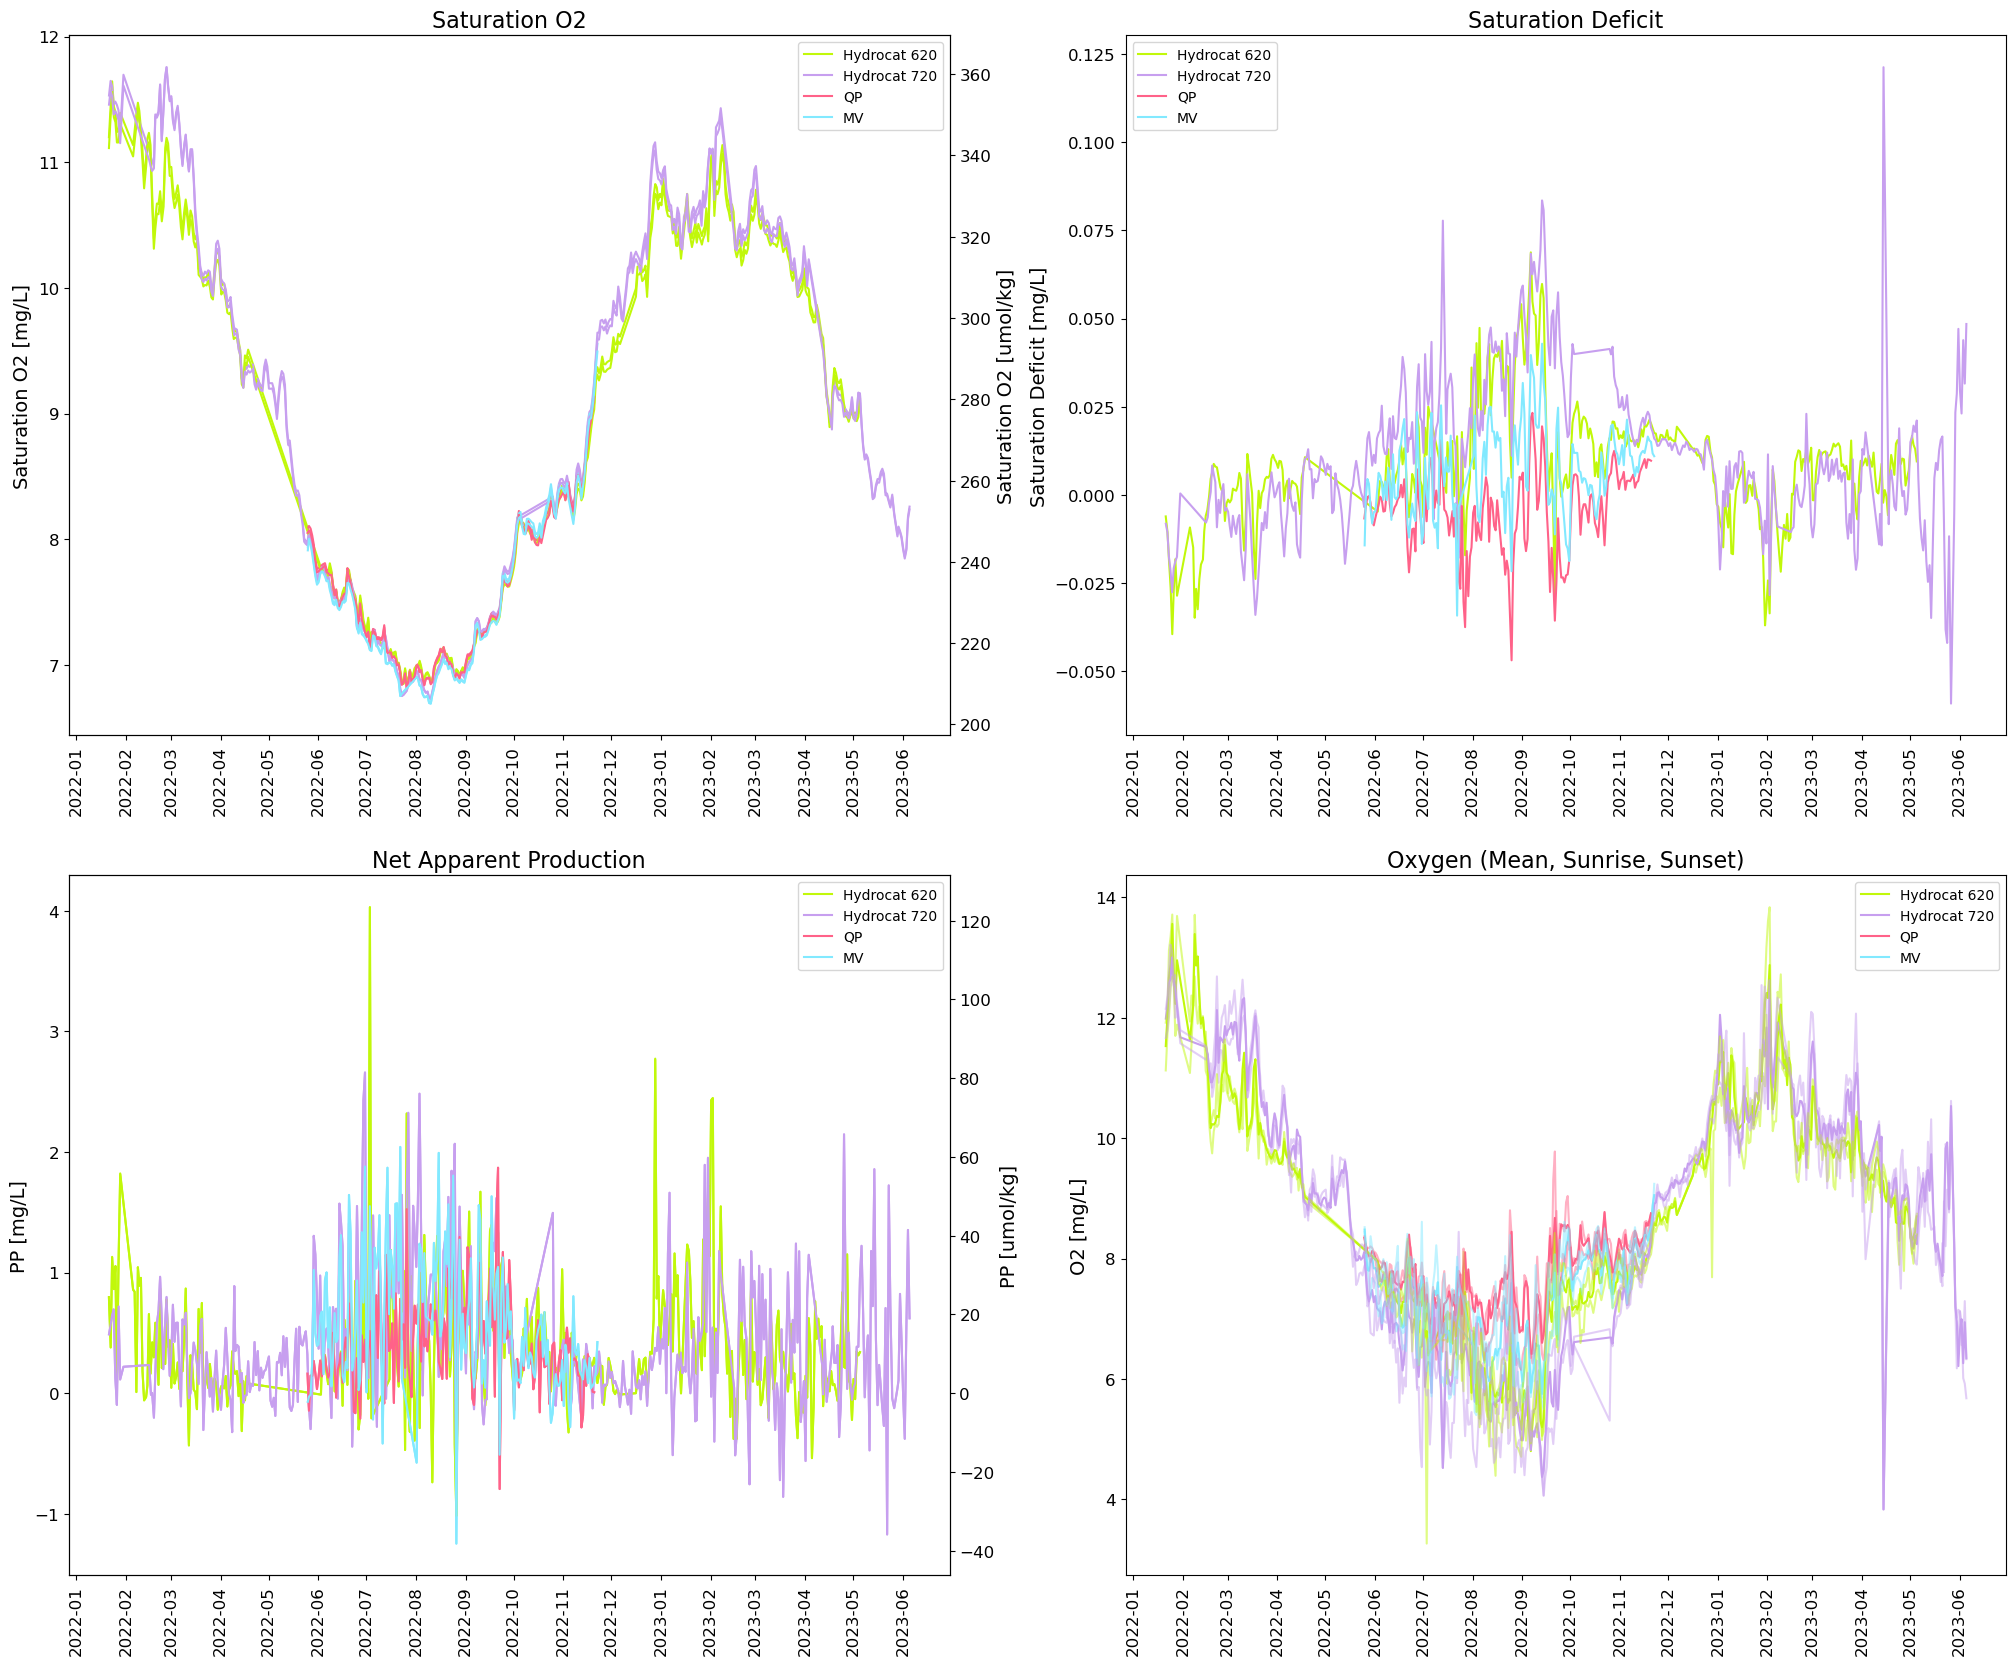

In [169]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [25,20])
axarr = axarr.flatten()

# Saturation O2 in mg/L
ax = axarr[0]
ax.set_title('Saturation O2', fontsize = 16)
ax.set_ylabel('Saturation O2 [mg/L]', fontsize = 14)
ax.plot(hydro620['Dawn'], hydro620['Sat O2 [mg/L]'], color = green, label = 'Hydrocat 620')
ax.plot(hydro720['Dawn'], hydro720['Sat O2 [mg/L]'], color = purple, label = 'Hydrocat 720')
ax.plot(qp['Dawn'], qp['Sat O2 [mg/L]'], color = pink, label = 'QP')
ax.plot(mv['Dawn'], mv['Sat O2 [mg/L]'], color = blue, label = 'MV')
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)

# Saturation O2 in umol/kg
ax2 = ax.twinx()
ax2.set_ylabel('Saturation O2 [umol/kg]', fontsize = 14)
ax2.plot(hydro620['Dawn'], hydro620['Sat O2 [umol/kg]'], color = green, label = 'Hydrocat 620')
ax2.plot(hydro720['Dawn'], hydro720['Sat O2 [umol/kg]'], color = purple, label = 'Hydrocat 720')
ax2.plot(qp['Dawn'], qp['Sat O2 [umol/kg]'], color = pink, label = 'QP')
ax2.plot(mv['Dawn'], mv['Sat O2 [umol/kg]'], color = blue, label = 'MV')
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.tick_params('x',labelsize = 12, labelrotation = 90)
ax2.tick_params('y',labelsize = 12)

# Saturation deficit in mg/L
ax = axarr[1]
ax.set_title('Saturation Deficit', fontsize = 16)
ax.set_ylabel('Saturation Deficit [mg/L]', fontsize = 14)
var = 'Sat Deficit [mg/L]' 
ax.plot(hydro620['Dawn'], hydro620[var], color = green, label = 'Hydrocat 620')
ax.plot(hydro720['Dawn'], hydro720[var], color = purple, label = 'Hydrocat 720')
ax.plot(qp['Dawn'], qp[var], color = pink, label = 'QP')
ax.plot(mv['Dawn'], mv[var], color = blue, label = 'MV')
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)

# PP in mg/L
ax = axarr[2]
ax.set_title('Net Apparent Production', fontsize = 16)
ax.set_ylabel('PP [mg/L]', fontsize = 14)
var = 'PP [mg/L]' 
ax.plot(hydro620['Dawn'], hydro620[var], color = green, label = 'Hydrocat 620')
ax.plot(hydro720['Dawn'], hydro720[var], color = purple, label = 'Hydrocat 720')
ax.plot(qp['Dawn'], qp[var], color = pink, label = 'QP')
ax.plot(mv['Dawn'], mv[var], color = blue, label = 'MV')
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)

# PP in umol/kg
ax2 = ax.twinx()
ax2.set_ylabel('PP [umol/kg]', fontsize = 14)
var = 'PP [umol/kg]' 
ax2.plot(hydro620['Dawn'], hydro620[var], color = green, label = 'Hydrocat 620')
ax2.plot(hydro720['Dawn'], hydro720[var], color = purple, label = 'Hydrocat 720')
ax2.plot(qp['Dawn'], qp[var], color = pink, label = 'QP')
ax2.plot(mv['Dawn'], mv[var], color = blue, label = 'MV')
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.tick_params('x',labelsize = 12, labelrotation = 90)
ax2.tick_params('y',labelsize = 12)

# Daylight, dusk, and dawn O2 in mg/L
ax = axarr[3]
ax.set_title('Oxygen (Mean, Sunrise, Sunset)', fontsize = 16)
ax.set_ylabel('O2 [mg/L]', fontsize = 14)
var = 'Daily O2 [mg/L]' 
ax.plot(hydro620['Dawn'], hydro620[var], color = green, label = 'Hydrocat 620')
ax.plot(hydro720['Dawn'], hydro720[var], color = purple, label = 'Hydrocat 720')
ax.plot(qp['Dawn'], qp[var], color = pink, label = 'QP')
ax.plot(mv['Dawn'], mv[var], color = blue, label = 'MV')
ax.legend()
var = 'Dawn DO [mg/L]' 
ax.plot(hydro620['Dawn'], hydro620[var], color = green, alpha = 0.5)
ax.plot(hydro720['Dawn'], hydro720[var], color = purple, alpha = 0.5)
ax.plot(qp['Dawn'], qp[var], color = pink, alpha = 0.5)
ax.plot(mv['Dawn'], mv[var], color = blue, alpha = 0.5)
var = 'Dusk DO [mg/L]' 
ax.plot(hydro620['Dawn'], hydro620[var], color = green, alpha = 0.5)
ax.plot(hydro720['Dawn'], hydro720[var], color = purple, alpha = 0.5)
ax.plot(qp['Dawn'], qp[var], color = pink, alpha = 0.5)
ax.plot(mv['Dawn'], mv[var], color = blue, alpha = 0.5)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)

# ∆DIC using Net Apparent Production and Redfield Ratio
### Conceptual Overview
#### Oxidation/remineralization of organic matter
The following reaction describes the respiration and photosynthesis of organic matter (Sarmiento & Gruber, 2006). 
$$\require{mhchem}$$   
$$\ce{OM + 150 O2 <=> 106 CO2 + 16 HNO3 + H3PO4 + 78 H2O}$$

#### Redfield Ratio
From this reaction, we arrive at the Redfield ratio: $106 C: 16 N: 1 P: 150 O_2$. We can rewrite this ratio in terms of DIC and TA as follows: $106\ \text{DIC}: -17\ \text{TA}: 150\ \text{O}_2$

*This is an explanation I wrote in a homework assigment for why the Redfield ratio in terms of DIC and TA is what it is.* The reaction produces 106 moles of carbon for every 150 moles of oxygen consumed (i.e. cell respiration), or it consumes 106 moles of carbon for every 150 moles of oxygen produced (i.e. photosynthesis). Further, the respiration of organic matter produces 16 moles of NO$_3^-$ and 1 mole of HPO$_4^{2-}$. Alkalinity under one definition is the ability of a solution to react with additional H$^+$. Generally, the charge of an anion is equal to the number of protons it will accept, except in the case of HPO$_4^{2-}$. HPO$_4^{2-}$ only accepts 1 proton to become H$_2$PO$_4^{-}$. Thus, 1 mole of NO$_3^-$ and 1 mole of HPO$_4^{2-}$ will each accept 1 mole of protons. Since we have 16 moles of NO$_3^-$, we multiply to get 16 moles of protons. In total, the products of aerobic respiration can accept 17 moles of H$^+$. This increases the free hydrogens in the solution and thus decreases alkalinity by 17 moles (or mole equivalents). 

#### Net Apparent Production
From [Oviatt et al. (2014)](https://www.sciencedirect.com/science/article/pii/S0272771417309319#bib25):

$$
\text{PP} = [\text{O}_2]_{\text{dusk}} - [\text{O}_2]_{\text{dawn}} - \text{K} \times \text{SD}
$$

#### Overview
To summarize, we can calculate the theoretical DIC produced from biology alone using PP (in some molar unit) and the Redfield ratio as follows:

$$ \Delta\text{DIC}_{\text{theoretical}} = \text{PP} \times \frac{-106 \ \text{C}}{150 \ \text{O}_2}$$


In [170]:
C_to_O2 = -106/150

hydro620['∆DIC'] = hydro620['PP [umol/kg]'] * C_to_O2
hydro720['∆DIC'] = hydro720['PP [umol/kg]'] * C_to_O2
qp['∆DIC'] = qp['PP [umol/kg]'] * C_to_O2
mv['∆DIC'] = mv['PP [umol/kg]'] * C_to_O2

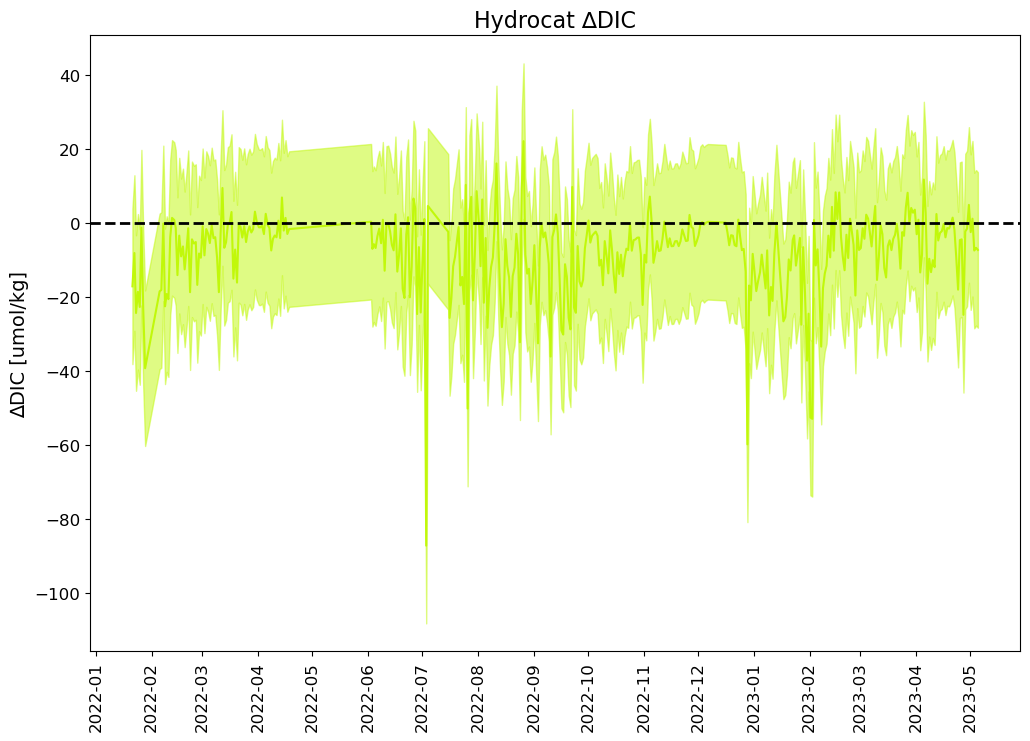

In [171]:
fig, ax = plt.subplots(figsize = [12,8])
ax.set_title('Hydrocat ∆DIC', fontsize = 16)
ax.set_ylabel('∆DIC [umol/kg]', fontsize = 14)
var = '∆DIC' 
ax.plot(hydro620['Dawn'], hydro620[var], color = green, label = 'Hydrocat 620')
# ax.plot(hydro720['Dawn'], hydro720[var], color = purple, label = 'Hydrocat 720')
# ax.plot(qp['Dawn'], qp[var], color = pink, label = 'QP')
# ax.plot(mv['Dawn'], mv[var], color = blue, label = 'MV')
ax.fill_between(hydro620['Dawn'], hydro620[var] - 21, hydro620[var] + 21, color = green, alpha = 0.5)
# ax.fill_between(hydro720['Dawn'], hydro720[var] - 21, hydro720[var] + 21, color = purple, alpha = 0.5)
# ax.fill_between(qp['Dawn'], qp[var] - 21, qp[var] + 21, color = pink, alpha = 0.5)
# ax.fill_between(mv['Dawn'], mv[var] - 21, mv[var] + 21, color = blue, alpha = 0.5)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)

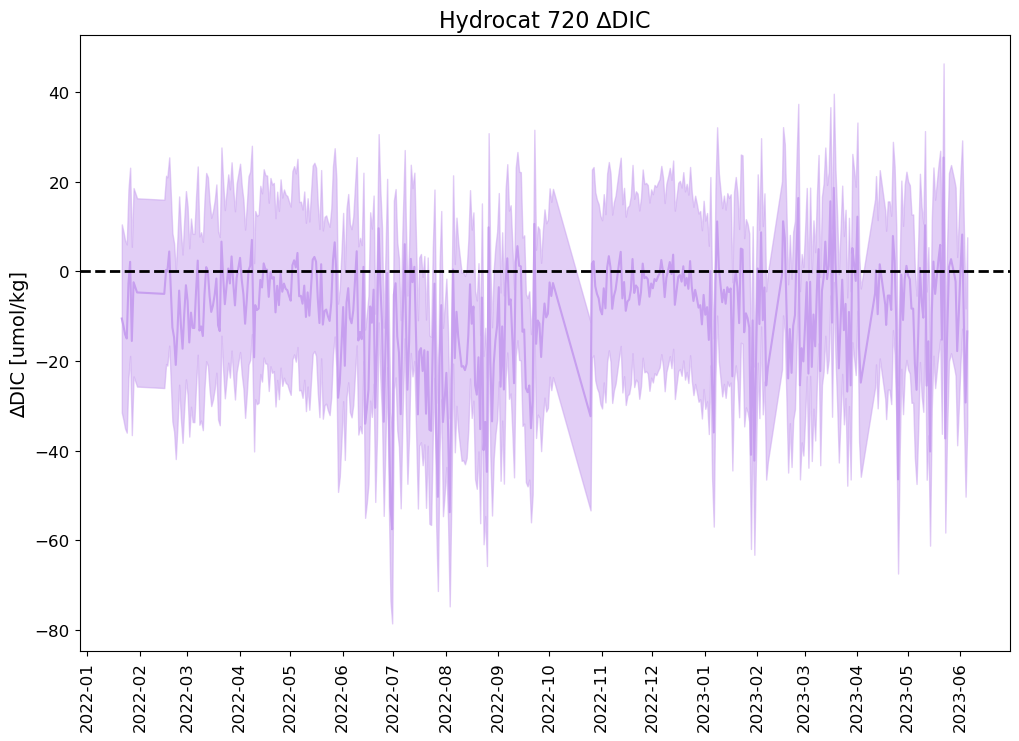

In [172]:
fig, ax = plt.subplots(figsize = [12,8])
ax.set_title('Hydrocat 720 ∆DIC', fontsize = 16)
ax.set_ylabel('∆DIC [umol/kg]', fontsize = 14)
var = '∆DIC' 
# ax.plot(hydro620['Dawn'], hydro620[var], color = green, label = 'Hydrocat 620')
ax.plot(hydro720['Dawn'], hydro720[var], color = purple, label = 'Hydrocat 720')
# ax.plot(qp['Dawn'], qp[var], color = pink, label = 'QP')
# ax.plot(mv['Dawn'], mv[var], color = blue, label = 'MV')
# ax.fill_between(hydro620['Dawn'], hydro620[var] - 21, hydro620[var] + 21, color = green, alpha = 0.5)
ax.fill_between(hydro720['Dawn'], hydro720[var] - 21, hydro720[var] + 21, color = purple, alpha = 0.5)
# ax.fill_between(qp['Dawn'], qp[var] - 21, qp[var] + 21, color = pink, alpha = 0.5)
# ax.fill_between(mv['Dawn'], mv[var] - 21, mv[var] + 21, color = blue, alpha = 0.5)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)

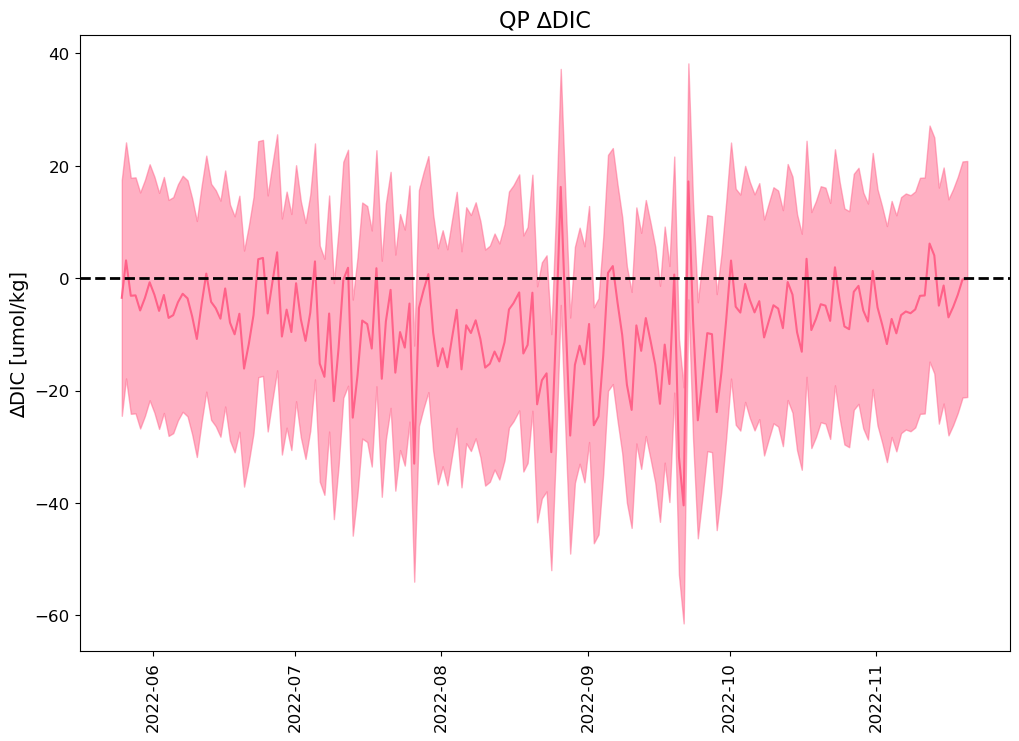

In [173]:
fig, ax = plt.subplots(figsize = [12,8])
ax.set_title('QP ∆DIC', fontsize = 16)
ax.set_ylabel('∆DIC [umol/kg]', fontsize = 14)
var = '∆DIC' 
# ax.plot(hydro620['Dawn'], hydro620[var], color = green, label = 'Hydrocat 620')
# ax.plot(hydro720['Dawn'], hydro720[var], color = purple, label = 'Hydrocat 720')
ax.plot(qp['Dawn'], qp[var], color = pink, label = 'QP')
# ax.plot(mv['Dawn'], mv[var], color = blue, label = 'MV')
# ax.fill_between(hydro620['Dawn'], hydro620[var] - 21, hydro620[var] + 21, color = green, alpha = 0.5)
# ax.fill_between(hydro720['Dawn'], hydro720[var] - 21, hydro720[var] + 21, color = purple, alpha = 0.5)
ax.fill_between(qp['Dawn'], qp[var] - 21, qp[var] + 21, color = pink, alpha = 0.5)
# ax.fill_between(mv['Dawn'], mv[var] - 21, mv[var] + 21, color = blue, alpha = 0.5)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)

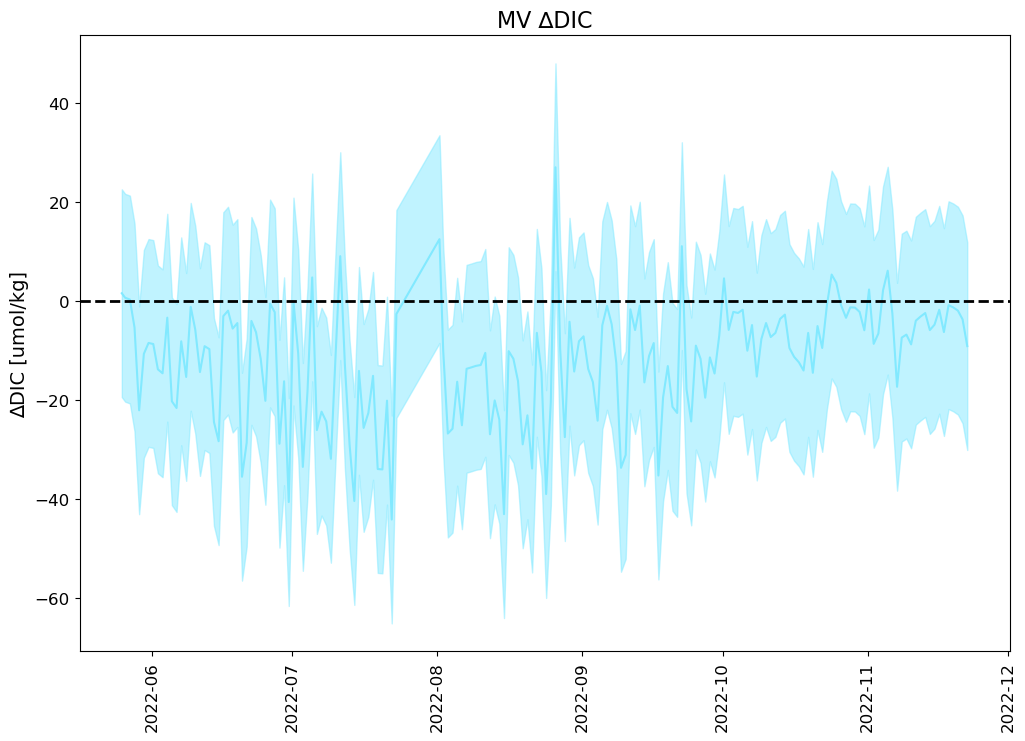

In [174]:
fig, ax = plt.subplots(figsize = [12,8])
ax.set_title('MV ∆DIC', fontsize = 16)
ax.set_ylabel('∆DIC [umol/kg]', fontsize = 14)
var = '∆DIC' 
# ax.plot(hydro620['Dawn'], hydro620[var], color = green, label = 'Hydrocat 620')
# ax.plot(hydro720['Dawn'], hydro720[var], color = purple, label = 'Hydrocat 720')
# ax.plot(qp['Dawn'], qp[var], color = pink, label = 'QP')
ax.plot(mv['Dawn'], mv[var], color = blue, label = 'MV')
# ax.fill_between(hydro620['Dawn'], hydro620[var] - 21, hydro620[var] + 21, color = green, alpha = 0.5)
# ax.fill_between(hydro720['Dawn'], hydro720[var] - 21, hydro720[var] + 21, color = purple, alpha = 0.5)
# ax.fill_between(qp['Dawn'], qp[var] - 21, qp[var] + 21, color = pink, alpha = 0.5)
ax.fill_between(mv['Dawn'], mv[var] - 21, mv[var] + 21, color = blue, alpha = 0.5)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.tick_params('y',labelsize = 12)
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)